In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from datetime import timedelta

Iniciando el pipeline optimizado para predicción de demanda...
Entrenando modelo para item_id: HOBBIES_1_001, store_id: CA_1
Número de filas para item_id=HOBBIES_1_001 y store_id=CA_1: 1941
Número de filas después de rellenar valores faltantes: 1941
Número de filas después de preprocesamiento: 1941
Forma de data: (1941, 14)
Forma de X después de generación: (1911, 30, 14)
Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0269 - val_loss: 0.0715
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0202 - val_loss: 0.0680
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0189 - val_loss: 0.0712
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0197 - val_loss: 0.0689
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0228 - val_loss: 0.0706
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0189 - val_loss: 0.0694
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0188 - val_loss: 0.0685
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0222 - val_loss: 0.0747
Epoch 9/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0189 - val_loss: 0.0684
Epoch 10/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0159 - val_loss: 0.0696
Epoch 11/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0171 - val_loss: 0.0677
Epoch 12/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

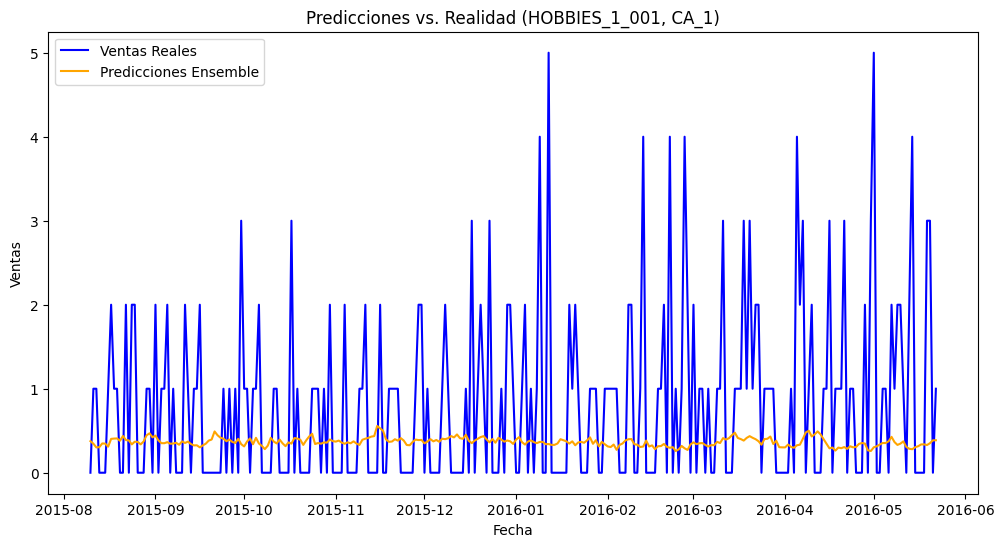

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from datetime import timedelta

# --- Configuración Inicial ---
print("Iniciando el pipeline optimizado para predicción de demanda...")

# Definir directorios relativos
current_dir = os.getcwd()
data_path = os.path.join(current_dir, "../data/raw/Dataframe_Final_Data_LSTM.csv")
models_dir = os.path.join(current_dir, "../data/models/")
os.makedirs(models_dir, exist_ok=True)

if not os.path.exists(data_path):
    raise FileNotFoundError(f"El archivo {data_path} no se encuentra.")

# Parámetros
item_id = 'HOBBIES_1_001'
store_id = 'CA_1'
initial_seq_length = 30
print(f"Entrenando modelo para item_id: {item_id}, store_id: {store_id}")

# --- Paso 1: Cargar y Preparar los Datos ---
df = pd.read_csv(data_path, parse_dates=['date'])
df_filtered = df[(df['item_id'] == item_id) & (df['store_id'] == store_id)].copy()
df_filtered = df_filtered.sort_values('date')

# Verificar si hay datos después del filtrado
if df_filtered.empty:
    raise ValueError(f"No hay datos para item_id: {item_id} y store_id: {store_id}. Verifica los filtros.")
print(f"Número de filas para item_id={item_id} y store_id={store_id}: {len(df_filtered)}")

# Rellenar fechas faltantes
date_range = pd.date_range(start=df_filtered['date'].min(), end=df_filtered['date'].max())
missing_dates = date_range.difference(df_filtered['date'])
if not missing_dates.empty:
    print(f"Faltan {len(missing_dates)} fechas. Rellenando con ventas = 0.")
    df_missing = pd.DataFrame({
        'date': missing_dates,
        'item_id': item_id,
        'store_id': store_id,
        'sales': 0,
        'snap_CA': 0,
        'sell_price': df_filtered['sell_price'].mean() if not df_filtered['sell_price'].isna().all() else 0,
        'event_name_1': 'NoEvent',
        'event_type_1': 'NoType',
        'event_name_2': 'NoEvent',
        'event_type_2': 'NoType',
        'wm_yr_wk': 0,
        'weekday': missing_dates.day_name(),
        'wday': missing_dates.dayofweek + 1,
        'month': missing_dates.month,
        'year': missing_dates.year
    })
    df_filtered = pd.concat([df_filtered, df_missing]).sort_values('date').reset_index(drop=True)

# Rellenar valores faltantes en columnas originales
df_filtered['sell_price'] = df_filtered['sell_price'].fillna(df_filtered['sell_price'].mean())
df_filtered['snap_CA'] = df_filtered['snap_CA'].fillna(0)
print(f"Número de filas después de rellenar valores faltantes: {len(df_filtered)}")

# Transformar las ventas para suavizar la distribución
df_filtered['sales'] = np.log1p(df_filtered['sales'])  # log(1 + sales) para manejar ceros

# Ingeniería de características avanzada
df_filtered['lag_1'] = df_filtered['sales'].shift(1)
df_filtered['lag_7'] = df_filtered['sales'].shift(7)
df_filtered['lag_14'] = df_filtered['sales'].shift(14)
df_filtered['rolling_mean_7'] = df_filtered['sales'].rolling(window=7).mean()
df_filtered['rolling_std_7'] = df_filtered['sales'].rolling(window=7).std()
df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek
df_filtered['is_weekend'] = df_filtered['day_of_week'].isin([5, 6]).astype(int)
df_filtered['month'] = df_filtered['date'].dt.month
df_filtered['event'] = df_filtered['event_name_1'].notna().astype(int)
df_filtered['snap'] = df_filtered['snap_CA']
df_filtered['price_change'] = df_filtered['sell_price'].pct_change()
df_filtered['week_of_year'] = df_filtered['date'].dt.isocalendar().week  # Añadir estacionalidad

# Rellenar valores NaN generados por shift y rolling
df_filtered = df_filtered.fillna(0)

# Verificar nuevamente el número de filas después del preprocesamiento
available_rows = len(df_filtered)
print(f"Número de filas después de preprocesamiento: {available_rows}")

# Ajustar seq_length dinámicamente si hay pocos datos
if available_rows <= 1:
    raise ValueError(f"No hay suficientes datos para procesar. Filas disponibles: {available_rows}.")
elif available_rows - 1 < initial_seq_length:
    seq_length = max(1, available_rows - 1)
    print(f"Advertencia: seq_length ajustado a {seq_length} debido a datos insuficientes.")
else:
    seq_length = initial_seq_length

# Normalizar datos
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['sales', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'day_of_week', 'is_weekend', 'month', 'event', 'snap', 'sell_price', 'price_change', 'week_of_year']
df_filtered[[f"{feat}_scaled" for feat in features]] = scaler.fit_transform(df_filtered[features])

# --- Paso 2: Crear Secuencias para LSTM ---
data = df_filtered[[f"{feat}_scaled" for feat in features]].values
print(f"Forma de data: {data.shape}")

# Verificar que data sea bidimensional
if len(data.shape) == 1:
    data = data.reshape(-1, 1)

# Generar secuencias
X, y = [], []
n_samples = len(data) - seq_length
if n_samples > 0:
    for i in range(n_samples):
        seq = data[i:i + seq_length, :]
        X.append(seq)
        y.append(data[i + seq_length, 0])
    X = np.array(X)
    y = np.array(y)
else:
    raise ValueError(f"No se pueden generar secuencias. Filas disponibles: {len(data)}, secuencia requerida: {seq_length}.")

print(f"Forma de X después de generación: {X.shape}")
if len(X.shape) != 3:
    raise ValueError(f"X no tiene 3 dimensiones. Forma actual: {X.shape}.")

# --- Paso 3: Dividir en Entrenamiento, Validación y Prueba ---
train_split = int(0.7 * len(X))
val_split = int(0.85 * len(X))
if train_split == 0 or val_split == train_split:
    raise ValueError(f"No hay suficientes secuencias para dividir. Número de secuencias: {len(X)}")
X_train, X_val, X_test = X[:train_split], X[train_split:val_split], X[val_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:val_split], y[val_split:]

# --- Paso 4: Modelo LSTM Optimizado ---
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(32, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = lstm_model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), 
                        callbacks=[early_stopping], verbose=1)

# --- Paso 5: Modelo XGBoost Optimizado ---
X_train_xgb = X_train.reshape((X_train.shape[0], -1))
X_val_xgb = X_val.reshape((X_val.shape[0], -1))
X_test_xgb = X_test.reshape((X_test.shape[0], -1))

xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
grid_search = GridSearchCV(xgb_model, xgb_params, cv=TimeSeriesSplit(n_splits=10), scoring='r2', verbose=1)
grid_search.fit(X_train_xgb, y_train)
xgb_model = grid_search.best_estimator_
print(f"Mejores parámetros XGBoost: {grid_search.best_params_}")

# --- Paso 6: Ensemble Dinámico ---
y_pred_lstm = lstm_model.predict(X_val, verbose=0).flatten()
y_pred_xgb = xgb_model.predict(X_val_xgb)

# Calcular pesos basados en R² en validación, evitando negativos
r2_lstm = max(0, r2_score(y_val, y_pred_lstm))  # Forzar no negativo
r2_xgb = max(0, r2_score(y_val, y_pred_xgb))    # Forzar no negativo
total_r2 = r2_lstm + r2_xgb
w_lstm = r2_lstm / total_r2 if total_r2 != 0 else 0.5
w_xgb = r2_xgb / total_r2 if total_r2 != 0 else 0.5
print(f"Pesos del ensemble - LSTM: {w_lstm:.2f}, XGBoost: {w_xgb:.2f}")

# Predicciones en prueba
y_pred_lstm_test = lstm_model.predict(X_test, verbose=0).flatten()
y_pred_xgb_test = xgb_model.predict(X_test_xgb)
y_pred_ensemble = w_lstm * y_pred_lstm_test + w_xgb * y_pred_xgb_test

# Desnormalizar
y_test_2d = y_test.reshape(-1, 1)
y_pred_ensemble_2d = y_pred_ensemble.reshape(-1, 1)
zeros_test = np.zeros((y_test_2d.shape[0], len(features)-1))
zeros_pred = np.zeros((y_pred_ensemble_2d.shape[0], len(features)-1))
y_test_to_transform = np.hstack((y_test_2d, zeros_test))
y_pred_to_transform = np.hstack((y_pred_ensemble_2d, zeros_pred))
y_test_original = scaler.inverse_transform(y_test_to_transform)[:, 0]
y_pred_ensemble_original = scaler.inverse_transform(y_pred_to_transform)[:, 0]

# Invertir la transformación logarítmica
y_test_original = np.expm1(y_test_original)  # exp(y) - 1 para revertir log1p
y_pred_ensemble_original = np.expm1(y_pred_ensemble_original)

# Métricas
mse = mean_squared_error(y_test_original, y_pred_ensemble_original)
mae = mean_absolute_error(y_test_original, y_pred_ensemble_original)
r2 = r2_score(y_test_original, y_pred_ensemble_original)
print("\nMétricas de Error (Ensemble):")
print(f"- MSE: {mse:.2f}")
print(f"- MAE: {mae:.2f}")
print(f"- R²: {r2:.2f}")

# Visualización
test_dates = df_filtered['date'].iloc[val_split + seq_length:].values
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label='Ventas Reales', color='blue')
plt.plot(test_dates, y_pred_ensemble_original, label='Predicciones Ensemble', color='orange')
plt.title(f'Predicciones vs. Realidad ({item_id}, {store_id})')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.savefig('predictions_vs_reality_ensemble.png')
print("Gráfico guardado como 'predictions_vs_reality_ensemble.png'")

# --- Paso 7: Predicciones Futuras ---
X_last = X_test[-1].reshape((1, seq_length, X.shape[2]))
X_last_xgb = X_test_xgb[-1].reshape(1, -1)
predictions = []
current_sequence = X_last.copy()

for _ in range(30):
    next_pred_lstm = lstm_model.predict(current_sequence, verbose=0)[0, 0]
    next_pred_xgb = xgb_model.predict(current_sequence.reshape(1, -1))[0]
    next_pred = w_lstm * next_pred_lstm + w_xgb * next_pred_xgb
    predictions.append(next_pred)
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = next_pred

# Desnormalizar predicciones
predictions = np.array(predictions).reshape(-1, 1)
predictions_to_transform = np.hstack((predictions, np.zeros((predictions.shape[0], len(features)-1))))
predictions_original = scaler.inverse_transform(predictions_to_transform)[:, 0]
predictions_original = np.expm1(predictions_original)  # Revertir log1p

# Fechas futuras
last_date = df_filtered['date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

print("\nPredicciones para los próximos 30 días:")
for date, pred in zip(future_dates, predictions_original):
    print(f"Predicción para {date.strftime('%Y-%m-%d')}: {pred:.2f} unidades")

# # Guardar modelos
# lstm_model.save(os.path.join(models_dir, f'lstm_optimized_{item_id}_{store_id}.h5'))
# xgb_model.save_model(os.path.join(models_dir, f'xgb_optimized_{item_id}_{store_id}.json'))
# print(f"Modelos guardados en {models_dir}")